**YOUR NAMES HERE**

Spring 2024

CS 443: Bio-inspired Machine Learning

# Project 4: Spiking Neural Networks

##### Week 3: Training the SNN on MNIST

### Reminder: AI Policy

To improve the quality of your learning and out of fairness to your hardworking classmates, AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions. This includes both written analysis, plotting, and code. I will only grade your work, not an AI's. I will stop grading your project if I notice AI-generated content (in any capacity).

In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt

plt.show()
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 9: Setting up Spiking Network for Training

In [2]:
from snn import SpikingNet

### 9a. Load in debug config file and create test SNN

In [13]:
# TODO: Load in your debug config file again (e.g. net_params_debug.json).
# As before, name the dictionary params

with open("net_params_debug.json", "r") as file:
    params = json.load(file)
    
print(params)
# TODO: Create a spiking net called net with the dictionary
np.random.seed(0)  # KEEP ME
net = SpikingNet(params)

{'input_layer': {'num_neurons': 11, 'trace_decay_rate': 0.95, 'num_time_steps': 350}, 'recurrent_layer': {'num_neurons': 3, 'trace_decay_rate': 0.95, 'v_decay_rate': 0.99, 'v_rest': -65, 'v_reset': -60, 'spike_thre': -52, 'voltage_decay_rate': 0.99, 'refrac_period': 3, 'adaptive_threshold': 0.05, 'adaptive_decay_rate': 0.999999, 'gain_wts': 100, 'max_wts': 0.3, 'norm_wts': 78.4, 'wts_update_+': 0.5, 'wts_update_-': 0.1}}


### 9b. Associate recurrent layer neurons with specific MNIST digits (classes)

The last step before we can implement training is handling how recurrent neurons become associated with certain classes and how the network predicts the class of data samples.

Implement and test the following methods in `SpikingNet`:
- `accuracy(self, y_pred, y_true)`: the usual
- `assign_neurons_to_classes(self, spike_record, y, num_classes=10)`: Assign each of the `H` units in the recurrent layer to a particular class that produces the most spikes over the `N` samples. **This is written for you.**
- `predict_class(self, spike_record, neuron_class_assignments, num_classes=10)`: Given the class assignments of each of the `H` units in the recurrent layer, predict the class of the `N` samples by voting based on the spike record.

#### Test: `predict_class`

In [14]:
spike_rec = np.array([[[1, 1, 0, 0, 0, 0],  # Sample 1
                       [0, 1, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 1],
                       [0, 1, 0, 0, 0, 1],
                       [0, 1, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0, 0]],
                      [[1, 1, 0, 1, 0, 0],  # Sample 2
                       [0, 1, 0, 0, 1, 0],
                       [0, 0, 1, 0, 0, 0],
                       [0, 1, 1, 0, 0, 0],
                       [0, 1, 1, 0, 0, 1],
                       [0, 1, 1, 0, 0, 0],
                       [0, 1, 1, 0, 0, 0]],
                      [[0, 1, 0, 0, 1, 0],  # Sample 3
                       [0, 1, 0, 0, 1, 1],
                       [0, 1, 0, 0, 1, 0],
                       [0, 1, 0, 0, 1, 0],
                       [0, 1, 0, 0, 1, 0],
                       [1, 1, 0, 0, 1, 0],
                       [1, 1, 1, 0, 1, 0]]])
neuron_class_assignments = np.array([1, 0, 1, 0, 0, 0])
y_pred = net.predict_class(spike_rec, neuron_class_assignments, num_classes=2)
print('For scenario C=2, N=3, T=7, H=6, the predicted classes are:')
print(y_pred)
print('and they should be:\n[0 1 0]')

spike_rec = np.array([[[1, 1, 1, 0, 0, 1],
                       [0, 1, 1, 0, 0, 1],
                       [0, 1, 1, 0, 0, 1],
                       [0, 1, 1, 0, 0, 1]],
                      [[1, 1, 1, 1, 0, 0],
                       [0, 1, 0, 0, 1, 0],
                       [0, 0, 1, 1, 0, 0],
                       [0, 1, 1, 0, 0, 1]],
                      [[0, 1, 0, 0, 0, 1],
                       [0, 1, 0, 0, 1, 1],
                       [1, 1, 0, 0, 1, 0],
                       [1, 1, 1, 0, 0, 1]]])
neuron_class_assignments = np.array([0, 1, 2, 1, 1, 0])
y_pred = net.predict_class(spike_rec, neuron_class_assignments, num_classes=3)
print('For scenario C=3, N=3, T=4, H=6, the predicted classes are:')
print(y_pred)
print('and they should be:\n[2 2 0]')

For scenario C=2, N=3, T=7, H=6, the predicted classes are:
[0 1 0]
and they should be:
[0 1 0]
For scenario C=3, N=3, T=4, H=6, the predicted classes are:
[2 2 0]
and they should be:
[2 2 0]


### 9c. Prepare config file for SNN that trains on MNIST

Make a new JSON config file (e.g. `net_params.json`) that contains the following default network configuration for MNIST (*these parameters largely come from Diehl & Cook (2015)*):

#### Input layer parameters
- Number of neurons: 784
- Trace decay rate: 0.95
- Simulation time of each sample: 350 msec

#### Recurrent layer parameters
- Number of neurons: 100
- Trace decay rate: 0.95
- Rest voltage: -65 mV
- Reset voltage: -60 mV
- Spike thresold: -52 mV
- Voltage (membrane potential) decay rate: 0.99
- Refractory period length: 5 time steps
- Increment to adaptive threshold everytime there is a spike: 0.05 mV
- Adaptive threshold decay rate (if there is no spike): 0.999999
- Gain on the recurrent weights (within-layer inhibition): 100
- Maximum input-to-excitatory learnable weights value: 0.3
- Normalization value for total input-to-excitatory learnable weights: 78.4
- (-) STDP learning rate: 0.0001
- (+) STDP learning rate: 0.01

Load in the new config file that you will use for training the SNN on MNIST below. Assign the dictionary to a variable called `params_mnist`.

In [2]:
with open("net_params.json", "r") as file:
    params_mnist = json.load(file)
print(params_mnist)

{'input_layer': {'num_neurons': 784, 'trace_decay_rate': 0.95, 'num_time_steps': 350}, 'recurrent_layer': {'num_neurons': 100, 'trace_decay_rate': 0.95, 'v_decay_rate': 0.99, 'v_rest': -65, 'v_reset': -60, 'spike_thre': -52, 'voltage_decay_rate': 0.99, 'refrac_period': 5, 'adaptive_threshold': 0.05, 'adaptive_decay_rate': 0.999999, 'gain_wts': 100, 'max_wts': 0.3, 'norm_wts': 78.4, 'wts_update_+': 0.01, 'wts_update_-': 0.0001}, 'recurrent_layer2': {'num_neurons': 50, 'trace_decay_rate': 0.95, 'v_decay_rate': 0.99, 'v_rest': -65, 'v_reset': -60, 'spike_thre': -52, 'voltage_decay_rate': 0.99, 'refrac_period': 5, 'adaptive_threshold': 0.05, 'adaptive_decay_rate': 0.999999, 'gain_wts': 100, 'max_wts': 0.3, 'norm_wts': 78.4, 'wts_update_+': 0.01, 'wts_update_-': 0.0001}}


### 9d. Load in MNIST dev sets

Run the following code to load in the MNIST dev set.

In [4]:
mnist_dev = np.load('data/mnist/mnist_dev.npz')
x_train_dev = mnist_dev['x_train_dev']
y_train_dev = mnist_dev['y_train_dev']
x_val_dev = mnist_dev['x_val_dev']
y_val_dev = mnist_dev['y_val_dev']

### 9e. Implement `train` method

#### Test (i): `train`: Validation set accuracy not checked.

Aside from the test code, you should see an animated plot showing the weights get updated as the 9 recurrent neurons in the net learn the first 20 MNIST samples. You should see the neurons whose weights are in the center, center-right, bottom-left, bottom-center change quite a bit as training progresses!

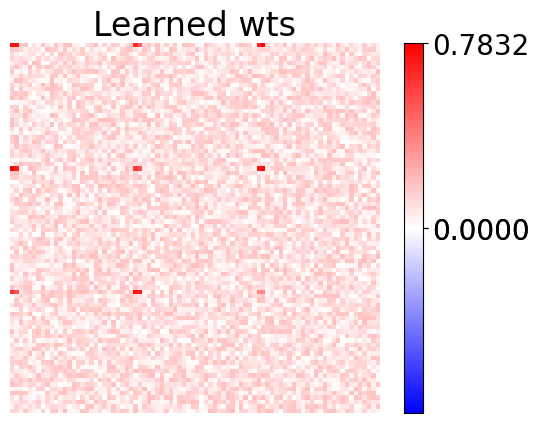

Train accuracy over 20 samples = 0.3500.
It should be approx 0.4000 OR 0.4500
Neuron class associations/assignments over 20 samples is:
[0 3 0 8 0 2 2 0 8] and it should be:
[0 0 0 3 4 5 9 0 0] OR
[0 0 0 0 5 3 8 4 0]


In [17]:
#Override number of neurons appropriate for MNIST for debugging
params_mnist['recurrent_layer']['num_neurons'] = 9  # TODO: CHANGE 'n_neurons' based on your naming convention
# Create the SNN
np.random.seed(5)  # KEEP ME
net_mnist = SpikingNet(all_params=params_mnist)

N_test_case_samps = 20
train_acc, train_neuron_labels = net_mnist.train(x_train_dev[:N_test_case_samps],
                                                 y_train_dev[:N_test_case_samps],
                                                 x_val=x_val_dev,
                                                 y_val=y_val_dev,
                                                 print_every=1,
                                                 plot_sample_voltage=False,
                                                 plot_wts_live=True,
                                                 plot_wt_rows_cols=(3, 3),
                                                 plot_pause=0.1)

print(f'Train accuracy over {N_test_case_samps} samples = {train_acc:.4f}.')
print('It should be approx 0.4000 OR 0.4500')
print(f'Neuron class associations/assignments over {N_test_case_samps} samples is:\n{train_neuron_labels} and it should be:')
print('''[0 0 0 3 4 5 9 0 0] OR''')
print('[0 0 0 0 5 3 8 4 0]')

#### Test (ii): `train`: Validation set accuracy checked.

You should NOT see a plot in this test! 

Pay attention to the test code below, but also in two cells below, check out example output. There should be 2 rounds of checking the validation set accuracy.

In [18]:
# Override number of neurons appropriate for MNIST for debugging
params_mnist['recurrent_layer']['n_neurons'] = 9  # TODO: CHANGE 'n_neurons' based on your naming convention
# Create the SNN
np.random.seed(5)  # KEEP ME
net_mnist = SpikingNet(all_params=params_mnist)

N_test_case_samps = 40
N_val_case_samps = 50
train_acc, train_neuron_labels = net_mnist.train(x_train_dev[:N_test_case_samps],
                                                 y_train_dev[:N_test_case_samps],
                                                 x_val=x_val_dev[:N_val_case_samps],
                                                 y_val=y_val_dev[:N_val_case_samps],
                                                 print_every=1,
                                                 val_every=15,
                                                 plot_sample_voltage=False,
                                                 plot_wts_live=False,
                                                 plot_wt_rows_cols=(3, 3),
                                                 plot_pause=0.01)
print(f'Train accuracy over {N_test_case_samps} samples = {train_acc:.4f}.')
print('It should be approx between 0.2500 and 0.4000.')

iteration =  0
iteration =  1
iteration =  2
iteration =  3
iteration =  4
iteration =  5
iteration =  6
iteration =  7
iteration =  8
iteration =  9
iteration =  10
iteration =  11
iteration =  12
iteration =  13
iteration =  14
iteration =  15
iteration =  16
iteration =  17
iteration =  18
iteration =  19
iteration =  20
iteration =  21
iteration =  22
iteration =  23
iteration =  24
iteration =  25
iteration =  26
iteration =  27
iteration =  28
iteration =  29
iteration =  30
iteration =  31
iteration =  32
iteration =  33
iteration =  34
iteration =  35
iteration =  36
iteration =  37
iteration =  38
iteration =  39
Train accuracy over 40 samples = 0.3250.
It should be approx between 0.2500 and 0.4000.


#### Test (iii): `train`: Fewer sample print outs

In this test, you should see sample progress print outs every 5 samples. Everything else should be the same as above.

In [19]:
# Override number of neurons appropriate for MNIST for debugging
params_mnist['recurrent_layer']['n_neurons'] = 9  # TODO: CHANGE 'n_neurons' based on your naming convention
# Create the SNN
np.random.seed(5)  # KEEP ME
net_mnist = SpikingNet(all_params=params_mnist)

N_test_case_samps = 40
N_val_case_samps = 50
train_acc, train_neuron_labels = net_mnist.train(x_train_dev[:N_test_case_samps],
                                                 y_train_dev[:N_test_case_samps],
                                                 x_val=x_val_dev[:N_val_case_samps],
                                                 y_val=y_val_dev[:N_val_case_samps],
                                                 print_every=5,
                                                 val_every=15,
                                                 plot_sample_voltage=False,
                                                 plot_wts_live=False,
                                                 plot_wt_rows_cols=(3, 3),
                                                 plot_pause=0.01)
print(f'Train accuracy over {N_test_case_samps} samples = {train_acc:.4f}.')
print('It should be approx between 0.2500 and 0.4000.')

iteration =  0
iteration =  5
iteration =  10
iteration =  15
iteration =  20
iteration =  25
iteration =  30
iteration =  35
Train accuracy over 40 samples = 0.3250.
It should be approx between 0.2500 and 0.4000.


#### Test (iv): `train`: Full MNIST dev set

This is a "mock" training run with the entire MNIST dev set for `1` epoch. This should take about a minute.

The training accuracy after 1 epoch should be approximately `0.5000`.

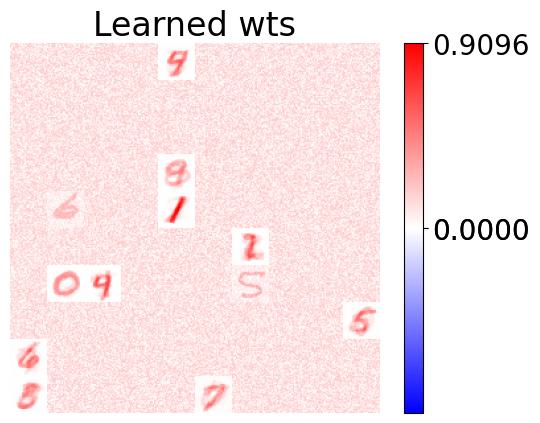

Train accuracy over 100 samples = 0.4600.


In [24]:
# Override number of neurons appropriate for MNIST for debugging
params_mnist['recurrent_layer']['num_neurons'] = 100  # TODO: CHANGE 'n_neurons' based on your naming convention
# Create the SNN
np.random.seed(5)  # KEEP ME
net_mnist = SpikingNet(all_params=params_mnist)

N_test_case_samps = len(x_train_dev)
N_val_case_samps = len(x_val_dev)
train_acc, train_neuron_labels = net_mnist.train(x_train_dev[:N_test_case_samps],
                                                 y_train_dev[:N_test_case_samps],
                                                 x_val=x_val_dev[:N_val_case_samps],
                                                 y_val=y_val_dev[:N_val_case_samps],
                                                 print_every=25,
                                                 val_every=200,
                                                 epochs=1,
                                                 plot_sample_voltage=False,
                                                 plot_wts_live=True,
                                                 plot_wt_rows_cols=(10, 10),
                                                 plot_pause=0.01)
print(f'Train accuracy over {N_test_case_samps} samples = {train_acc:.4f}.')

## Task 10: Train SNN to classify MNIST images

### 10a. Load in MNIST dataset

Use `mnist.py` to load in the train, validation, and test sets of the MNIST dataset below.

**Notes:**
1. You are welcome to pick whatever validation set size you like. 500-1000 samples is a reasonable validation set size since checking the validation accuracy during training is computationally intensive.
2. Set the max feature value to be 128 (*the default*).

In [5]:
from mnist import get_mnist

x_train_f, y_train, x_test_f, y_test, x_val_f, y_val = get_mnist(500)

2024-05-12 12:53:51.316413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
mnist_net = SpikingNet(all_params=params_mnist)

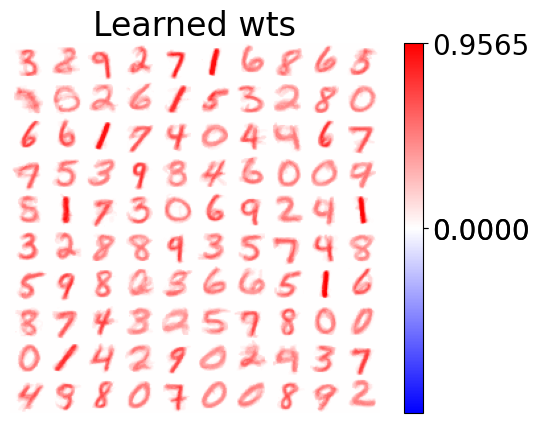

KeyboardInterrupt: 

In [25]:
train_acc, train_neuron_labels = mnist_net.train(x_train_f,
                                                 y_train,
                                                 x_val=x_val_f,
                                                 y_val=y_val,
                                                 print_every=25,
                                                 val_every=200,
                                                 epochs=1,
                                                 plot_sample_voltage=False,
                                                 plot_wts_live=True,
                                                 plot_wt_rows_cols=(10, 10),
                                                 plot_pause=0.01)

### 10b. Train your SNN

Train your spiking network on MNIST and evaluate the accuracy on the test set! This task is open ended, but please make sure that you meet all the requirements.

#### Requirements

1. If you make any hyperparameter changes to your MNIST training JSON config file from above, duplicate and load it below so the above test code still works.
2. Your goal is to achieve ≥ 80% classification accuracy on the MNIST test set.

#### Suggestions
- Your SNN should not need that much data to achieve the desired accuracy. A good starting point is just `N=5000` training samples! Adjust based on training time. Training for more than 1-2 hours should not be necessary if you have a fairly recent computer (*you can also run this on Colab but select the CPU runtime rather than the GPU since the SNN code is NOT GPU-accelerated with TensorFlow.*).
    - Decrease the number of recurrent layer neurons, if necessary, to keep the runtime reasonable on your computer. Note that this could impact the maximum accuracy that you obtain.
- 1 epoch of training should be sufficient!
- Use a validation set so that you can peek at out-of-training-sample classification performance. It is **VERY** computationally intensive to process every validation sample through your network, so set `val_every` to check the validation accuracy only a few times throughout the whole course of training.
- It's fun to see your network train live (and helpful to make sure everything is working)! Having the live wt plot turned on should not slow things down too much (assuming you use a `plot_pause` close to `0`), but if you need to you can turn off all plotting to minimize overhead.
- Modify `print_every` so that you get regular updates on the progress of training. It's not helpful/can slow things down if it's too frequent, however.
- **Be careful when setting up your training!** Looking at test code can be helpful, but the test code intentionally sets things so it will run fast and/or help with debugging, which may not be good decisions for a large training session.

In [28]:
preds, neuron_labels = mnist_net.predict(x_test_f[:500],y_test[:500])
acc = mnist_net.accuracy(preds,y_test[:500])
print(acc)

0.85


### 10c. Questions

**Question 4:** What accuracy did you get on your training and test sets?

**Question 5:** Make an image plot of your final weights. Print out the neuron class assignments reshaped to the same arrangement as the weights (e.g. (10,10) for 100 neurons). How close is the correspondence between each neuron's weight appearance and the associated class?

**Answer 4:**

**Answer 5:**

In [ ]:
from viz import draw_grid_image

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **AI (e.g. ChatGPT, Copilot, etc.) should NOT be used in ANY way on this project and extensions.** This includes both written analysis, plotting, and code. We will only grade **your** work, not an AI's. **We will stop grading your project if we notice AI-generated content (to any capacity).**

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1. Explore effect of parameters

You can do a formal grid or random hyperparameter search, or experiment by hand. Report the effects of certain hyperparameters on accuracy/wts/etc.

### 2. Your own dataset

Try Fashion MNIST, EMNIST, STL-10, or any others that interest you. Be aware, however, that you will likely need to turn hyperparameters (as with any neural net, hyperparameters that work on one dataset may not work well on another...).

### 3. Deeper spiking network

Try adding another recurrent layer to the network and use STDP to train a separate set of wts from the middle-to-final layer. Use this second set of wts to make class predictions.

In this extension we added a 2nd recurrent layer to see if we would be able to obtain better results. A SpikingNet2 class was created and all functions that needed modification were updated. The hyperparameters were kept the same as the first layer except we cut the number of neurons by half (50). Everything seems to be working as expected but for some reason we obtain very bad results atleast when tested on the dev set. I am unsure if during predication mode if both layers need to set their is_learning function to False or just the top layer. I tried missing around and seeing what the wts for both layers were doing and it seems like they are updating but for some reason do not capture the input data at all as we get an accuracy of ~10% which is what we expect for random  

In [4]:
from snn import SpikingNet2
mnist_dev = np.load('data/mnist/mnist_dev.npz')
x_train_dev = mnist_dev['x_train_dev']
y_train_dev = mnist_dev['y_train_dev']
x_val_dev = mnist_dev['x_val_dev']
y_val_dev = mnist_dev['y_val_dev']

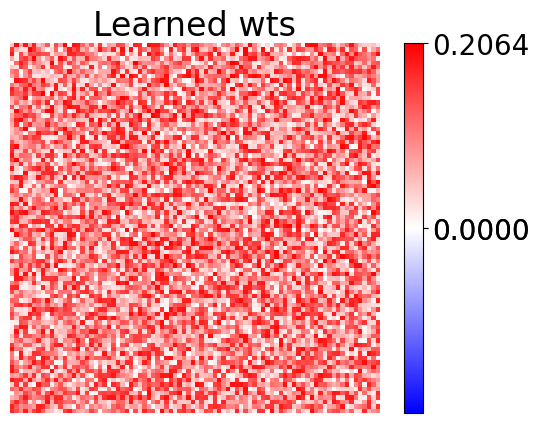

[[0.646 0.078 0.842 1.    1.   ]
 [0.27  0.813 1.    0.218 0.611]
 [1.    0.13  1.    1.    1.   ]
 [1.    1.    1.    1.    0.419]
 [0.759 0.996 1.    0.7   1.   ]] hhh
[[0.045 0.18  0.042 0.183 0.099]
 [0.201 0.166 0.011 0.038 0.092]
 [0.071 0.003 0.033 0.012 0.056]
 [0.189 0.199 0.001 0.086 0.118]
 [0.079 0.187 0.101 0.134 0.18 ]] ttt
[[0.646 0.078 0.842 1.    1.   ]
 [0.27  0.813 1.    0.218 0.611]
 [1.    0.13  1.    1.    1.   ]
 [1.    1.    1.    1.    0.419]
 [0.759 0.996 1.    0.7   1.   ]] hhh
[[0.045 0.18  0.042 0.183 0.099]
 [0.201 0.166 0.011 0.038 0.092]
 [0.071 0.003 0.033 0.012 0.056]
 [0.189 0.199 0.001 0.086 0.118]
 [0.079 0.187 0.101 0.134 0.18 ]] ttt
[[0.646 0.078 0.842 1.    1.   ]
 [0.27  0.813 1.    0.218 0.611]
 [1.    0.13  1.    1.    1.   ]
 [1.    1.    1.    1.    0.419]
 [0.759 0.996 1.    0.7   1.   ]] hhh
[[0.045 0.18  0.042 0.183 0.099]
 [0.201 0.166 0.011 0.038 0.092]
 [0.071 0.003 0.033 0.012 0.056]
 [0.189 0.199 0.001 0.086 0.118]
 [0.079 0.187 0.10

In [7]:
#Override number of neurons appropriate for MNIST for debugging
params_mnist['recurrent_layer2']['num_neurons'] = 9  # TODO: CHANGE 'n_neurons' based on your naming convention
print(params_mnist)
# Create the SNN
np.random.seed(5)  # KEEP ME
mnist_net = SpikingNet2(all_params=params_mnist)

N_test_case_samps = 20
train_acc, train_neuron_labels = mnist_net.train(x_train_dev[:N_test_case_samps],
                                                 y_train_dev[:N_test_case_samps],
                                                 x_val=x_val_dev,
                                                 y_val=y_val_dev,
                                                 print_every=1,
                                                 plot_sample_voltage=False,
                                                 plot_wts_live=True,
                                                 plot_wt_rows_cols=(3, 3),
                                                 plot_pause=0.1)

print(f'Train accuracy over {N_test_case_samps} samples = {train_acc:.4f}.')
print('It should be approx 0.4000 OR 0.4500')
print(f'Neuron class associations/assignments over {N_test_case_samps} samples is:\n{train_neuron_labels} and it should be:')
print('''[0 0 0 3 4 5 9 0 0] OR''')
print('[0 0 0 0 5 3 8 4 0]')

### 4. Experiment with SNN setup

Analyze how removing/changing components of the network influence the results and learning. For example, how important is it to have recurrent connections? Do we need 350 msec per sample? What if we allow multiple neurons to spike at once? And so on.

### 5. Mini-batch support

A major limitation of the SNN is the lack of mini-batch support. Adding batch processing would greatly improve runtime if STDP learning is still effective. This is an active area of research. For example, you may average the STDP weight updates across all neurons that spike at a given time (see https://arxiv.org/pdf/1909.02549.pdf). If you have any ideas, feel free to implement, explore, and report on this!

### 6. Maximize MNIST accuracy

The SNN that you implemented is capable of achieving 95% test accuracy on MNIST. Try to achieve that! Looking at Diehl & Cook (2015) might be helpful. This probably will require considerably training for considerably longer than in the base project. They used 2000 neurons and multiple epochs in the training session that produced the best accuracy. In my testing, it's possible to get decent improvements with 250-500 neurons.

### 7. Animate and visualize Poisson spike trains

For example, reshape the Poisson spike train to match the input image shape and visualize the spatial pattern of spikes over time (e.g. as a heatmap).

### 8. More advanced decoder

Rather than use the simple voting strategy to decode/predict class labels, try a simple softmax decoder or even an MLP decoder.